In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc
import time
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib
########

In [2]:
# New libraries introduced in this notebook
# Disable WandB programmatically to avoid interactive API key prompts in notebooks
import os
os.environ['WANDB_DISABLED'] = 'true'
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import TrainingArguments, Trainer, set_seed
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
# from transformers import pipeline
# Note: we intentionally do not import wandb here to avoid triggering interactive login prompts
from huggingface_hub import login
import torch
import torch.nn as nn
import ast

/home/012/r/rx/rxh210037/.conda/envs/llmenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
set_seed(39)

In [139]:
df = pd.read_csv('emotion_detection.csv')

label_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# create a new column "labels" that stores vectors
df["labels"] = df[label_cols].values.tolist()

print(df[["Tweet", "labels"]].head())


                                               Tweet  \
0  “Worry is a down payment on a problem you may ...   
1  Whatever you decide to do make sure it makes y...   
2  @Max_Kellerman  it also helps that the majorit...   
3  Accept the challenges so that you can literall...   
4  My roommate: it's okay that we can't spell bec...   

                              labels  
0  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]  
1  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]  
2  [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]  
3  [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]  
4  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  


In [140]:
df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,labels
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]"
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]"
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [141]:
# 70% train, 15% val, 15% test
train_df, testval_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(testval_df, test_size=0.5, random_state=42)
print("Train:", len(train_df), "Validation:", len(val_df), "Test:", len(test_df))


Train: 5406 Validation: 1159 Test: 1159


In [ ]:
# Build DatasetDict so that we can use the  Datasets library
train_dataset = Dataset.from_pandas(train_df) 
val_dataset   = Dataset.from_pandas(val_df)
test_dataset  = Dataset.from_pandas(test_df)

In [ ]:
# Build DatasetDict so that we can use the  Datasets library
train_val_subset = DatasetDict({
    "train": train_dataset,
    "valid": val_dataset,
    "test":  test_dataset
})

In [ ]:
train_val_subset 

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'labels', '__index_level_0__'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'labels', '__index_level_0__'],
        num_rows: 1159
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'labels', '__index_level_0__'],
        num_rows: 1159
    })
})

In [145]:
# Now you can access labels
print(train_val_subset['train']['labels'][0])  

[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]


## Load Tokenizer


In [ ]:
# Load the tokenizer and model from the Hugging Face Hub
model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)



In [ ]:
# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch["Tweet"], truncation=True, padding="max_length", max_length=228)

train_val_subset = train_val_subset.map(tokenize, batched=True)

Map: 100%|██████████| 1159/1159 [00:00<00:00, 9875.29 examples/s] 


In [148]:

train_val_subset


DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1159
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1159
    })
})

In [ ]:
# Set the format for PyTorch tensors since we will use PyTorch for modeling

train_val_subset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

## Load ModernBERT Model


In [ ]:
# Define the model and training parameters for multi-label classification
num_labels = len(label_cols)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [151]:
# ---- Load evaluation metric ----
f1 = evaluate.load("f1", "multilabel")

def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    # Apply sigmoid to convert logits → probabilities
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (probs > 0.5).astype(int)
    f1_macro = f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
    return {"eval_f1_macro": f1_macro}

In [152]:
model_folder = Path("./bert_multilabel")  # change path if needed
model_folder.mkdir(exist_ok=True, parents=True)
run_name = "stack_exp_imb_exp1"

training_args = TrainingArguments(
    seed=42,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    weight_decay=0.01,
    learning_rate=2e-5,
    optim="adamw_torch",

    # Saving + evaluation
    output_dir=str(model_folder),
    eval_strategy="steps",
    eval_steps=20,
    save_strategy="steps",
    save_steps=20,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,

    # Logging
    logging_strategy="steps",
    logging_steps=20,
    run_name=run_name,
    # Disable automatic reporting to external trackers (wandb) and rely on local logging
    report_to=[],
    fp16=True,   #use mixed precision if GPU supports
)

In [153]:
# ---- Class imbalance handling ----
def calculate_pos_weights(dataset):
    num_labels = len(dataset["train"]["labels"][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    for label_array in dataset["train"]["labels"]:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

pos_weights = calculate_pos_weights(train_val_subset)

In [154]:
# ---- Custom Trainer with BCE loss ----
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # BCE requires float targets
        outputs = model(**inputs)
        logits = outputs.get("logits")
        device = next(model.parameters()).device
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [155]:
# ---- Trainer ----
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_val_subset["train"],
    eval_dataset=train_val_subset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/tmp/ipykernel_927429/3376363660.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [156]:
# ---- GPU memory cleanup helper ----
def free_gpu_memory():
    import gc
    gc.collect()
    torch.cuda.empty_cache()


In [157]:
# ---- Training ----
try:
    trainer.train()
except RuntimeError as e:
    if "CUDA out of memory" in str(e):
        print("⚠️ CUDA OOM detected. Freeing memory and retrying...")
        free_gpu_memory()
    else:
        raise e

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Step,Training Loss,Validation Loss,F1 Macro
20,4.646100,1.104157,0.242452
40,4.389700,1.074369,0.310908
60,4.031600,1.074125,0.316375
80,4.422700,1.033984,0.373226
100,3.946400,1.022130,0.407716
120,4.182600,0.985427,0.404020
140,3.899700,0.944708,0.432285
160,3.854700,0.956439,0.426021
180,3.603200,0.904290,0.454912
200,3.552100,0.895886,0.465114


In [ ]:
# evaluation on validation 
test_metrics = trainer.evaluate(train_val_subset["valid"])
print("Test Metrics:", test_metrics)

Test Metrics: {'eval_loss': 0.7717040181159973, 'eval_model_preparation_time': 0.0019, 'eval_f1_macro': 0.5730343953279977, 'eval_runtime': 2.323, 'eval_samples_per_second': 498.925, 'eval_steps_per_second': 62.419}


In [159]:
trainer.save_model("./trained_emotion_model")
tokenizer.save_pretrained("./trained_emotion_model")


('./trained_emotion_model/tokenizer_config.json',
 './trained_emotion_model/special_tokens_map.json',
 './trained_emotion_model/tokenizer.json')

In [160]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(train_val_subset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [161]:
print(valid_labels)

[[0 1 0 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [162]:
train_output = trainer.predict(train_val_subset["train"])

# Get probabilities from logits
train_logits = train_output.predictions
train_probs = sigmoid(train_logits)
train_labels = np.array(train_output.label_ids.astype(int))

In [163]:
test_output = trainer.predict(train_val_subset["test"])

# Get probabilities from logits
test_logits = test_output.predictions
test_probs = sigmoid(test_logits)
test_labels = np.array(test_output.label_ids.astype(int))

In [ ]:
# Find optimal thresholds for each label based on validation set
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [165]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [166]:
optimal_thresholds

[np.float32(0.52535224),
 np.float32(0.53799725),
 np.float32(0.40253955),
 np.float32(0.6526289),
 np.float32(0.43758535),
 np.float32(0.7961333),
 np.float32(0.4825892),
 np.float32(0.5813019),
 np.float32(0.52960515),
 np.float32(0.50101566),
 np.float32(0.8040895)]

In [167]:
f1 = evaluate.load('f1','multilabel')
def compute_metrics_val(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_macro':f1_macro['f1'],}

In [168]:
compute_metrics_val((valid_logits, valid_labels), optimal_thresholds)

{'f1_macro': 0.57446756942778}

In [169]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[ 604  127]
  [  92  336]]

 [[ 832  176]
  [  73   78]]

 [[ 509  195]
  [  75  380]]

 [[ 883   66]
  [  70  140]]

 [[ 617  121]
  [  68  353]]

 [[ 979   62]
  [  43   75]]

 [[ 663  182]
  [  48  266]]

 [[ 865  154]
  [  56   84]]

 [[ 605  213]
  [  82  259]]

 [[ 992   99]
  [  34   34]]

 [[1077   30]
  [  39   13]]]


In [ ]:
# Visualization function for multilabel classification evaluation
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


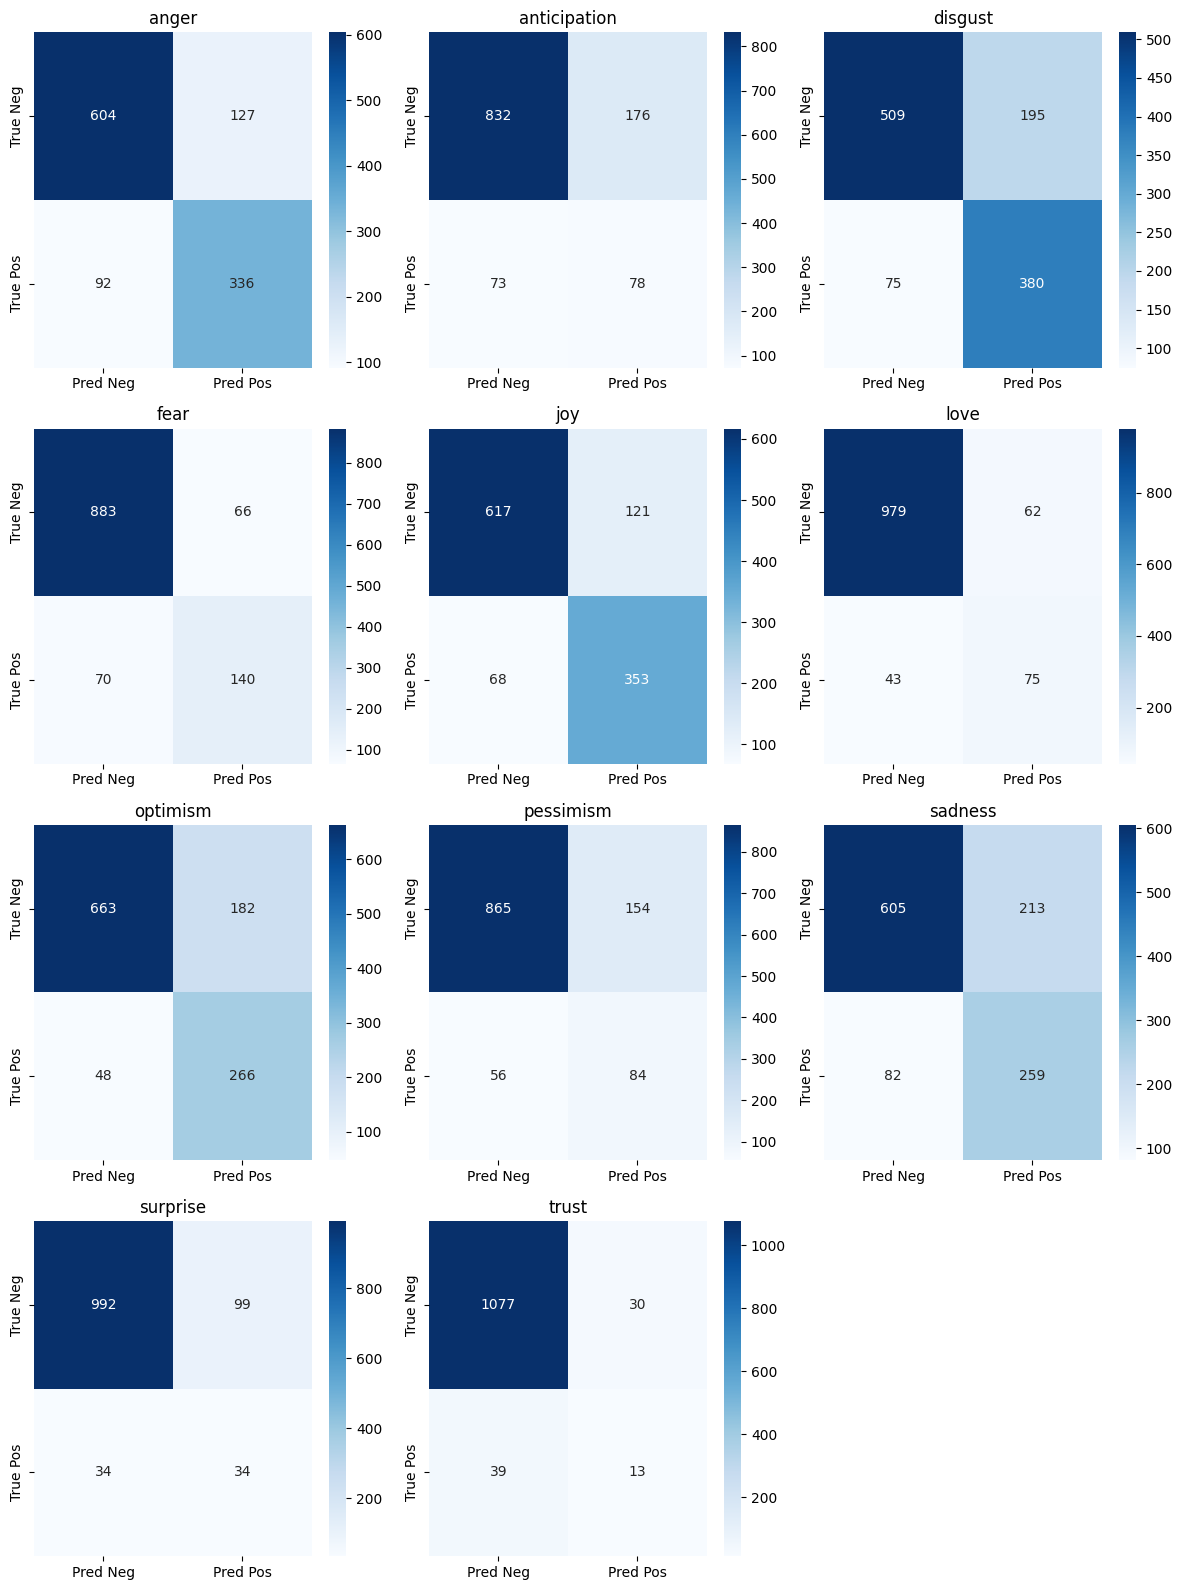

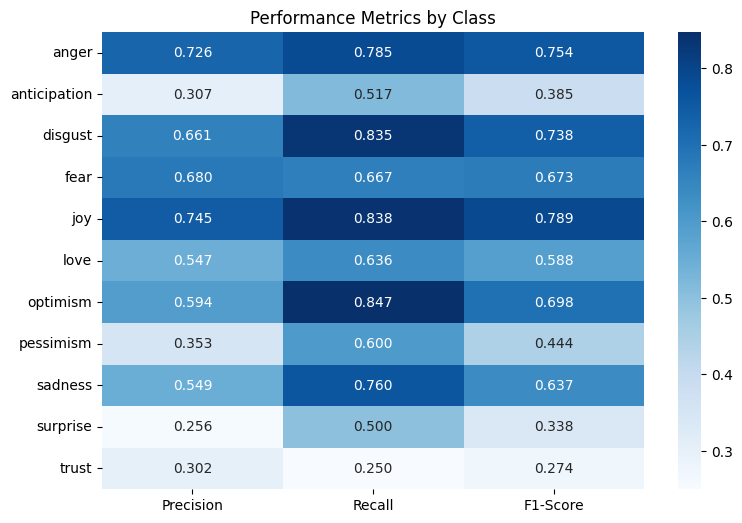

<Figure size 1200x533.333 with 0 Axes>

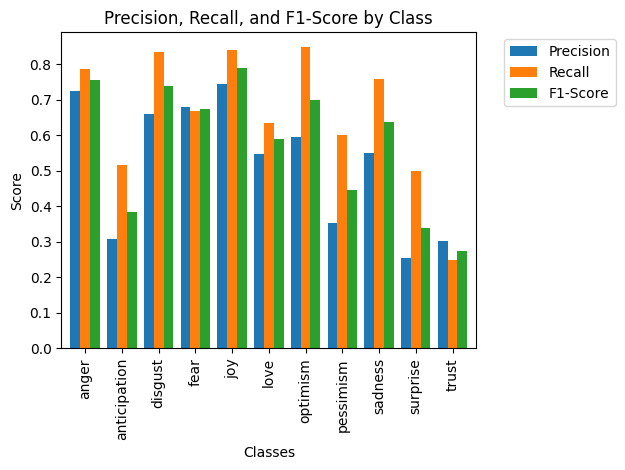

{'macro_avg': {'precision': np.float64(0.5198932215237496),
  'recall': np.float64(0.6576520092963694),
  'f1': np.float64(0.57446756942778)},
 'per_class': {'Precision': {'anger': 0.7257019438444925,
   'anticipation': 0.30708661417322836,
   'disgust': 0.6608695652173913,
   'fear': 0.6796116504854369,
   'joy': 0.7447257383966245,
   'love': 0.5474452554744526,
   'optimism': 0.59375,
   'pessimism': 0.35294117647058826,
   'sadness': 0.548728813559322,
   'surprise': 0.2556390977443609,
   'trust': 0.3023255813953488},
  'Recall': {'anger': 0.7850467289719626,
   'anticipation': 0.5165562913907285,
   'disgust': 0.8351648351648352,
   'fear': 0.6666666666666666,
   'joy': 0.838479809976247,
   'love': 0.635593220338983,
   'optimism': 0.8471337579617835,
   'pessimism': 0.6,
   'sadness': 0.7595307917888563,
   'surprise': 0.5,
   'trust': 0.25},
  'F1-Score': {'anger': 0.7542087542087542,
   'anticipation': 0.3851851851851852,
   'disgust': 0.7378640776699029,
   'fear': 0.6730769

In [171]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=label_cols, figsize=(12, 8))

In [172]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 560.


In [173]:
checkpoint = str(model_folder/f'checkpoint-{560}')
checkpoint

'bert_multilabel/checkpoint-560'

In [174]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [175]:
test_set_tokenized = train_val_subset["test"]
test_set_tokenized

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1159
})

In [ ]:
# Prepare test set for evaluation
# Note: We need to convert labels to float for BCEWithLogitsLoss
test_set_tokenized.set_format(type='torch')
test_set_tokenized = (test_set_tokenized
          .map(lambda x : {"float_label": x["labels"].to(torch.float)}, remove_columns=["labels", "__index_level_0__"])
          .rename_column("float_label", "label"))

test_set_tokenized = test_set_tokenized.remove_columns(label_cols)

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

Map: 100%|██████████| 1159/1159 [00:00<00:00, 2172.54 examples/s]


In [177]:
test_set_tokenized

Dataset({
    features: ['ID', 'Tweet', 'input_ids', 'attention_mask', 'label'],
    num_rows: 1159
})

In [178]:
training_args = TrainingArguments(
    seed = 42,
    output_dir="./results",
    per_device_eval_batch_size=8,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

In [179]:

from functools import partial

compute_metrics_fn = partial(compute_metrics_val, thresholds=optimal_thresholds)

In [180]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    processing_class=tokenizer,
)

In [181]:
free_gpu_memory()

In [182]:
test_results= trainer.evaluate()

In [183]:
test_results

{'eval_loss': 0.8154461979866028,
 'eval_model_preparation_time': 0.0019,
 'eval_f1_macro': 0.5520475948030218,
 'eval_runtime': 2.3847,
 'eval_samples_per_second': 486.011,
 'eval_steps_per_second': 60.804}

In [184]:
test_output = trainer.predict(test_set_tokenized)

In [185]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))


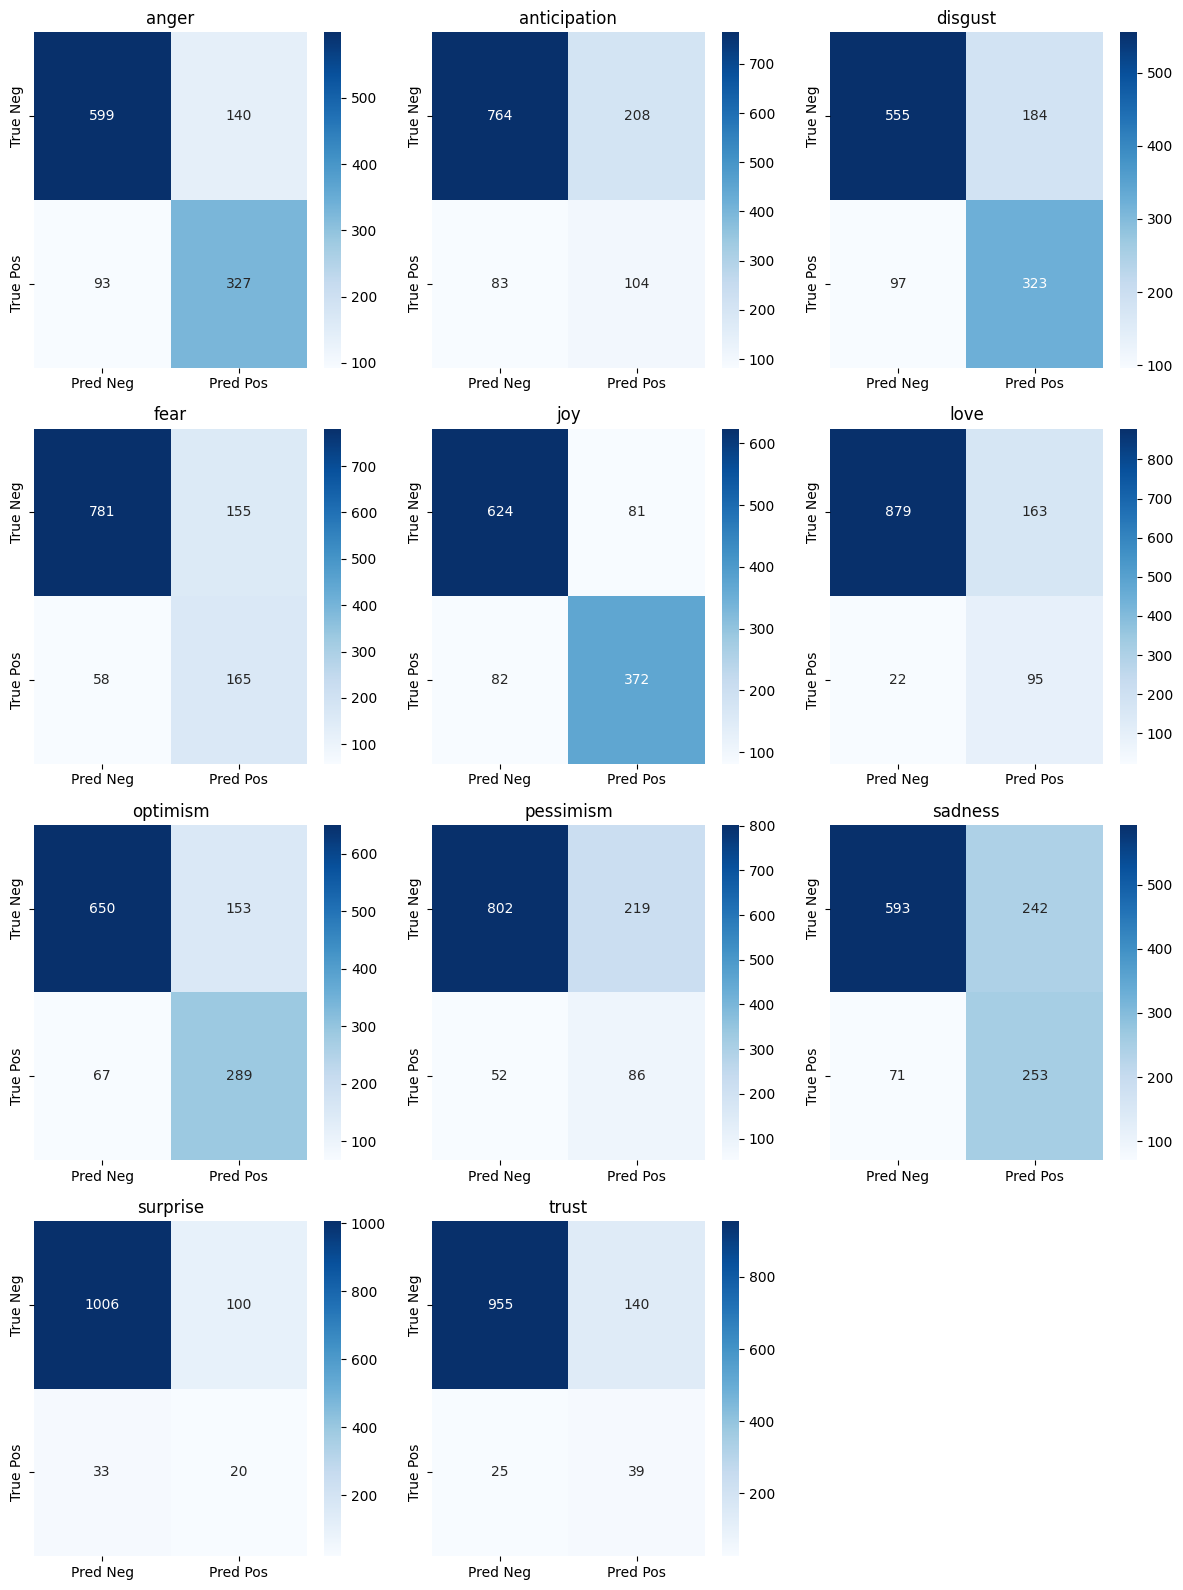

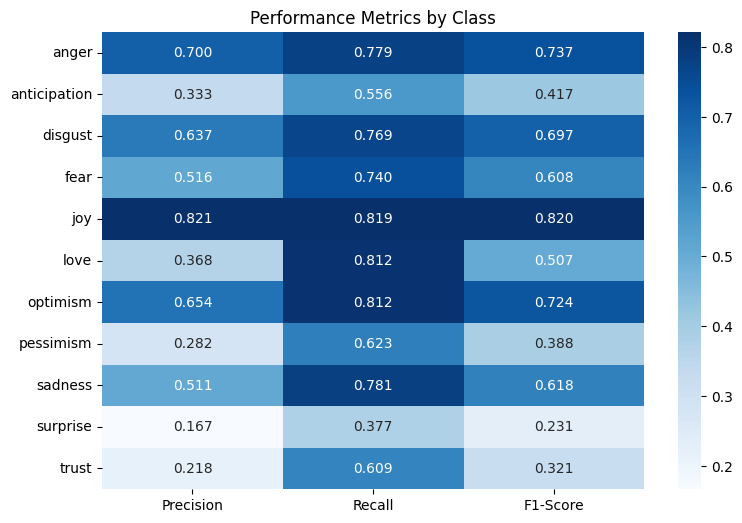

<Figure size 1200x533.333 with 0 Axes>

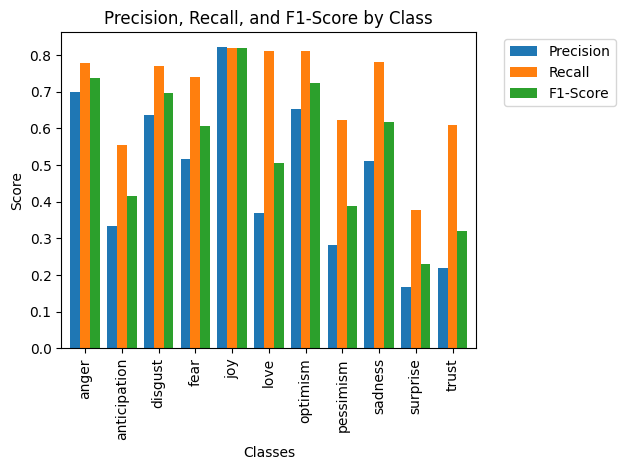

{'macro_avg': {'precision': np.float64(0.4733755164454724),
  'recall': np.float64(0.6979647284292193),
  'f1': np.float64(0.5516646363629419)},
 'per_class': {'Precision': {'anger': 0.7002141327623126,
   'anticipation': 0.3333333333333333,
   'disgust': 0.6370808678500987,
   'fear': 0.515625,
   'joy': 0.8211920529801324,
   'love': 0.3682170542635659,
   'optimism': 0.6538461538461539,
   'pessimism': 0.2819672131147541,
   'sadness': 0.5111111111111111,
   'surprise': 0.16666666666666666,
   'trust': 0.21787709497206703},
  'Recall': {'anger': 0.7785714285714286,
   'anticipation': 0.5561497326203209,
   'disgust': 0.7690476190476191,
   'fear': 0.7399103139013453,
   'joy': 0.8193832599118943,
   'love': 0.811965811965812,
   'optimism': 0.8117977528089888,
   'pessimism': 0.6231884057971014,
   'sadness': 0.7808641975308642,
   'surprise': 0.37735849056603776,
   'trust': 0.609375},
  'F1-Score': {'anger': 0.7373167981961668,
   'anticipation': 0.4168336673346693,
   'disgust': 

In [186]:
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=label_cols, figsize=(12, 8))

In [187]:
# set mappings as above
model.config.id2label = {i: label for i, label in enumerate(label_cols)}
model.config.label2id = {label: i for i, label in enumerate(label_cols)}

# save updated config into the checkpoint folder
model.save_pretrained(checkpoint)        # checkpoint is your folder path
tokenizer.save_pretrained(checkpoint)

from transformers import pipeline
# then create pipeline with the checkpoint path as you were doing
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0,
    return_all_scores=True,
    function_to_apply="sigmoid"
)

Device set to use cuda:0
/home/012/r/rx/rxh210037/.conda/envs/llmenv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [188]:
sample = test_df['Tweet'][0]
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.04691658914089203},
  {'label': 'anticipation', 'score': 0.61998051404953},
  {'label': 'disgust', 'score': 0.051491279155015945},
  {'label': 'fear', 'score': 0.6480576992034912},
  {'label': 'joy', 'score': 0.31025171279907227},
  {'label': 'love', 'score': 0.035400114953517914},
  {'label': 'optimism', 'score': 0.9310605525970459},
  {'label': 'pessimism', 'score': 0.5347689986228943},
  {'label': 'sadness', 'score': 0.5888917446136475},
  {'label': 'surprise', 'score': 0.03627030923962593},
  {'label': 'trust', 'score': 0.5284440517425537}]]

In [189]:
def get_positive_labels(pipeline_output, optimal_thresholds, label2id=None):

   positive_labels = []

   for pred_set in pipeline_output:
       # Get scores for all labels
       scores = [pred['score'] for pred in pred_set]
       labels = [pred['label'] for pred in pred_set]

       # Get positions where score > threshold for that label
       sample_positives = [
           label for label, score, threshold in zip(labels, scores, optimal_thresholds)
           if score >= threshold
       ]

       positive_labels.append(sample_positives)

   return positive_labels


In [190]:
results = get_positive_labels(preds, optimal_thresholds)
results

[['anticipation', 'optimism', 'sadness']]

In [191]:
def predict_batch(examples):
    return {"predictions": custom_pipeline(examples["Tweet"], truncation=True)}

results = test_set_tokenized.map(predict_batch, batched=True, batch_size=16)



Map: 100%|██████████| 1159/1159 [00:10<00:00, 109.57 examples/s]


In [192]:

predictions = results['predictions']
predictions[0:3]


[[{'label': 'anger', 'score': tensor(0.2620)},
  {'label': 'anticipation', 'score': tensor(0.5387)},
  {'label': 'disgust', 'score': tensor(0.2337)},
  {'label': 'fear', 'score': tensor(0.8228)},
  {'label': 'joy', 'score': tensor(0.2181)},
  {'label': 'love', 'score': tensor(0.1544)},
  {'label': 'optimism', 'score': tensor(0.1724)},
  {'label': 'pessimism', 'score': tensor(0.7373)},
  {'label': 'sadness', 'score': tensor(0.6415)},
  {'label': 'surprise', 'score': tensor(0.2209)},
  {'label': 'trust', 'score': tensor(0.0570)}],
 [{'label': 'anger', 'score': tensor(0.8452)},
  {'label': 'anticipation', 'score': tensor(0.6418)},
  {'label': 'disgust', 'score': tensor(0.8509)},
  {'label': 'fear', 'score': tensor(0.2083)},
  {'label': 'joy', 'score': tensor(0.0930)},
  {'label': 'love', 'score': tensor(0.0238)},
  {'label': 'optimism', 'score': tensor(0.0645)},
  {'label': 'pessimism', 'score': tensor(0.3801)},
  {'label': 'sadness', 'score': tensor(0.6735)},
  {'label': 'surprise', 'sco

In [193]:
results = get_positive_labels(predictions, optimal_thresholds)
results[0:3]

[['anticipation', 'fear', 'pessimism', 'sadness'],
 ['anger', 'anticipation', 'disgust', 'sadness', 'surprise'],
 ['anticipation', 'fear', 'optimism', 'sadness']]

In [194]:
def predict_emotions(text, threshold=0.5):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=228
    ).to(model.device)

    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits).detach().cpu().numpy()[0]

    # convert to 0/1 using threshold
    preds = (probs >= threshold).astype(int)

    return {label: int(pred) for label, pred in zip(label_cols, preds)}

# Example
print(predict_emotions("I am so happy and optimistic today!"))
print(predict_emotions("This makes me angry and sad."))



{'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 1, 'love': 1, 'optimism': 1, 'pessimism': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}
{'anger': 1, 'anticipation': 0, 'disgust': 1, 'fear': 0, 'joy': 0, 'love': 0, 'optimism': 0, 'pessimism': 1, 'sadness': 1, 'surprise': 0, 'trust': 0}


## How is ModernBERT different from BERT? 
ModernBERT is a “refreshed” BERT-like encoder that retains the core idea of bidirectional context, but enhances it by using rotary positional embeddings, more efficient attention, gated activations (GeGLU), and training on a much larger and more diverse dataset.  It also supports much longer sequences (8,192 tokens) and aims to provide a better speed vs performance tradeoff than older encoders.
In many tasks, you’d expect ModernBERT to match or outperform BERT while being more efficient or scalable, especially for longer-context or code-enabled tasks.